In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import ISLP

In [2]:
from ISLP import load_data
from ISLP import models

boston=load_data('Boston')
boston.head()


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [3]:
#a) fitting the cubic model 
from ISLP.models import ModelSpec as MS, poly, sklearn_sm
X = 'dis'
y = boston['nox']

poly_dis = MS([poly(X, degree = 3)]).fit(boston)
M = sm.OLS(y,poly_dis.transform(boston)).fit()
print(M.summary())
#We may conclude that all polynomial terms are significant

                            OLS Regression Results                            
Dep. Variable:                    nox   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     419.3
Date:                Fri, 18 Oct 2024   Prob (F-statistic):          2.71e-136
Time:                        23:23:36   Log-Likelihood:                 690.44
No. Observations:                 506   AIC:                            -1373.
Df Residuals:                     502   BIC:                            -1356.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                  0

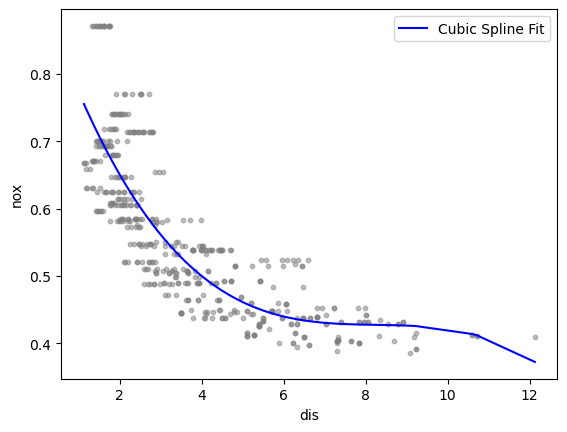

In [4]:

sorted_idx = boston['dis'].argsort()
sorted_dis = boston['dis'].iloc[sorted_idx]
sorted_fitted = M.fittedvalues[sorted_idx]
plt.scatter(boston['dis'], y, color='gray', s=10, alpha=0.5)
plt.plot(sorted_dis, sorted_fitted, color='blue', label='Cubic Spline Fit')
plt.xlabel('dis')
plt.ylabel('nox')
plt.legend()
plt.show()

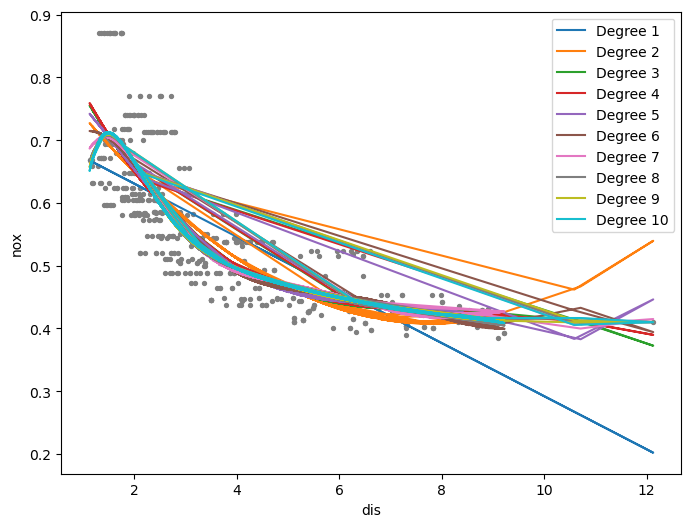

Degree: 1, RSS: 2.768562858969276
Degree: 2, RSS: 2.035261868935257
Degree: 3, RSS: 1.9341067071790703
Degree: 4, RSS: 1.9329813272985943
Degree: 5, RSS: 1.9152899610843042
Degree: 6, RSS: 1.8782572985081645
Degree: 7, RSS: 1.8494836145829785
Degree: 8, RSS: 1.835629689067688
Degree: 9, RSS: 1.8333308044915937
Degree: 10, RSS: 1.8321711239313423


In [5]:
#b 
rss = []
plt.figure(figsize=(8, 6))
plt.scatter(boston[X], y, color='gray', s=8)
for degree in range(1, 11): # 1 till 10
    poly_dis = MS([poly(X, degree=degree)]).fit(boston)
    M = sm.OLS(y, poly_dis.transform(boston)).fit()
    
    rss_val = np.sum((M.resid) ** 2) #calculating rss for each poly 
    rss.append(rss_val)
    plt.plot(boston[X], M.fittedvalues, label=f'Degree {degree}')
    
plt.xlabel('dis')
plt.ylabel('nox')
plt.legend()
plt.show()


for degree, rss_value in zip(range(1, 11), rss): #printing rss as well 
    print(f'Degree: {degree}, RSS: {rss_value}')


# we see with increasing poly degree the fit gets better and the bias reduces and this in trn reduces the rss

In [6]:
#c cross validation
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)
from sklearn.model_selection import train_test_split

cv_error = np.zeros(10)
H = np.array(boston['dis'])
M = sklearn_sm(sm.OLS)
for i, d in enumerate(range(1,11)):
    X = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M,
                          X,
                          y,
                          cv=boston.shape[0])
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error

array([0.00552387, 0.00407945, 0.00387476, 0.00388752, 0.00416486,
       0.00538428, 0.01106878, 0.0081214 , 0.01761638, 0.00443034])


we can see in our case for degree 3 the cv_error value is the loswest thus the optimal polynomial fit is cubic. first it decreases, then increases due to overfitting as per the bias vairance tradeoff, higher polynomials in reducing the bias have led to overfititng model

In [8]:
#d
from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import ns, bs
X = boston['dis']
print(boston['dis'].min(), boston['dis'].max())


1.1296 12.1265


In [9]:
bs_dis = MS([bs('dis', internal_knots=[4,7,11])])
Xbs = bs_dis.fit_transform(boston)
M = sm.OLS(y, Xbs).fit()
print(M.summary())

                            OLS Regression Results                            
Dep. Variable:                    nox   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     212.3
Date:                Fri, 18 Oct 2024   Prob (F-statistic):          7.32e-134
Time:                        23:23:38   Log-Likelihood:                 693.75
No. Observations:                 506   AIC:                            -1374.
Df Residuals:                     499   BIC:                            -1344.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

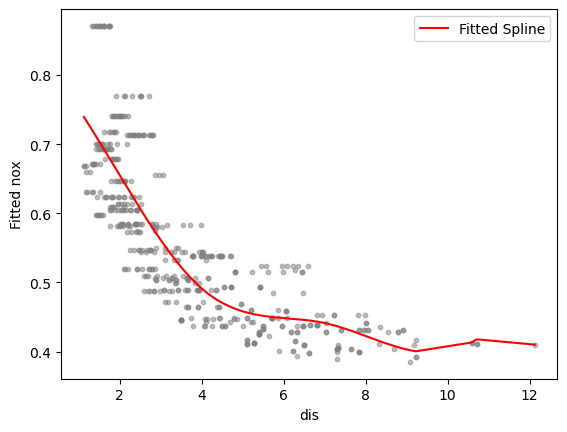

In [10]:
sorted_idx = boston['dis'].argsort()
sorted_dis = boston['dis'][sorted_idx]
sorted_fitted = M.fittedvalues[sorted_idx]
plt.scatter(boston['dis'], y, color='gray', s=10, alpha = 0.5)
plt.plot(sorted_dis, sorted_fitted, label='Fitted Spline', color='red')
plt.xlabel('dis')
plt.ylabel('Fitted nox')
plt.legend()
plt.show()

#we get a realy good fit, r2 value is high

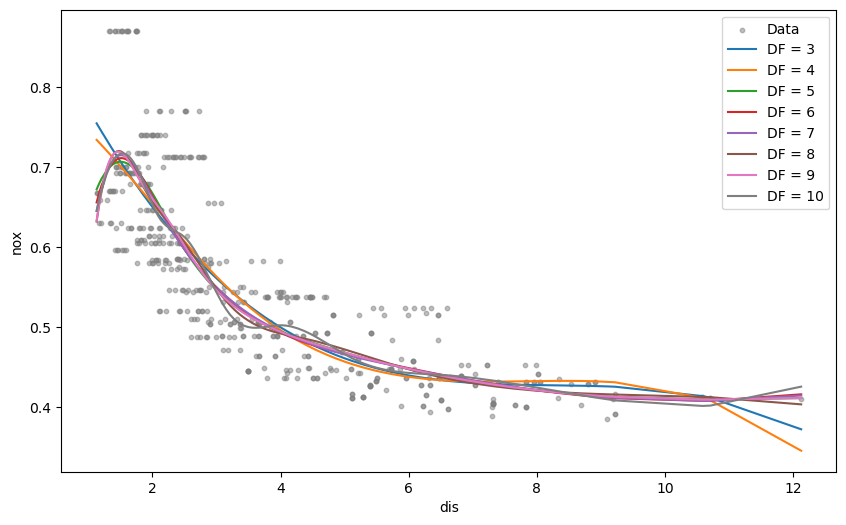

Degrees of Freedom: 3, RSS: 1.9341067071790703
Degrees of Freedom: 4, RSS: 1.922774992811925
Degrees of Freedom: 5, RSS: 1.8401728014885235
Degrees of Freedom: 6, RSS: 1.8339659031602091
Degrees of Freedom: 7, RSS: 1.829884445923284
Degrees of Freedom: 8, RSS: 1.8169950567252333
Degrees of Freedom: 9, RSS: 1.825652510387056
Degrees of Freedom: 10, RSS: 1.792534889556134


In [11]:
#e 
rss_values = []
plt.figure(figsize=(10, 6))
plt.scatter(boston['dis'], y, color='gray', s=10, alpha=0.5, label='Data')
for df in range(3, 11):
    bs_dis = MS([bs('dis', df=df)])
    Xbs = bs_dis.fit_transform(boston)
    M = sm.OLS(y, Xbs).fit()
    
    rss = np.sum(M.resid ** 2)
    rss_values.append(rss)
    sorted_fitted = M.fittedvalues[sorted_idx]
    plt.plot(sorted_dis, sorted_fitted, label=f'DF = {df}')
plt.xlabel('dis')
plt.ylabel('nox')
plt.legend()
plt.show()

for df, rss in zip(range(3,11), rss_values):
    print(f"Degrees of Freedom: {df}, RSS: {rss}")

As degrees of freedom increase, the RSS generally decreases, with the best balance between model fit and complexity occurring around 8 to 10 degrees of freedom. After 9 degrees of freedom, there's a slight increase in RSS, indicating potential overfitting risks.

In [13]:
from sklearn.model_selection import KFold
cv_error = np.zeros(9)
M = sklearn_sm(sm.OLS)
cv = KFold(n_splits=10,shuffle=True,random_state=1)
for d in range(3,12):
    bs_dis = MS([bs('dis', df=d)]).fit(boston)
    Xcross = bs_dis.transform(boston)
    Mat_CV = cross_validate(M,Xcross,y,cv=cv)
    cv_error[d-3] = np.mean(Mat_CV['test_score'])
cv_error

array([0.00387002, 0.00388453, 0.0037093 , 0.0037177 , 0.00372454,
       0.00371579, 0.00375893, 0.00371381, 0.00373558])

In [14]:
#The optimal model is obtained for 5 degrees of freedom but results seem unstable.